<a href="https://colab.research.google.com/github/tomonari-masada/course2022-stats2/blob/main/05_divergent_transitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. サンプリングがうまくいかない場合の例
* 密度関数がhigh curvatureであるとき、サンプリングが上手くいかないことがある。
 * high curvatureになっている部分が、サンプリングによって全くカバーされなかったりする。
* この場合、reparameterizationを使うと、問題が解決することがある。
 * https://mc-stan.org/docs/2_29/stan-users-guide/reparameterization.html

## 5.0 準備

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 20220307

## 5.1 サンプリングがうまく行かない理由
* 参考資料
 * https://mc-stan.org/docs/2_29/reference-manual/divergent-transitions.html
* HMCは、勾配を使ってfirst-orderの近似を行っているため、high curvatureな場所では、本当に求めたいものから大きく外れてしまうことがある。すると、サンプリングがパラメータ空間内での単なるランダムウォークに近くなってしまい、密度関数の"濃淡"を反映しないものになってしまう。
 * 別の参考資料 https://norimune.net/3149

## 5.2 例題
* 下のような確率分布を考える( https://mc-stan.org/docs/2_29/stan-users-guide/reparameterization.html )。
$$\begin{align} 
y & \sim N(0, 3^2) \\
x_i & \sim N(0, e^y), \text{ $i=1,\ldots, 9$ }  
\end{align}$$


* 同時分布を式で書くと・・・
$$p(y, x_1, \ldots, x_9) = p(y) \prod_{i=1}^9 p(x_i | y)$$
where
$$ p(y) = \frac{1}{\sqrt{2\pi 3^2}} \exp\bigg( - \frac{y^2}{2 \times 3^2}\bigg)  $$
and
$$ p(x_i | y) = \frac{1}{\sqrt{2\pi e^y}} \exp\bigg( - \frac{x_i^2}{2e^y} \bigg) $$

* この分布の問題点
 * $y$の値が小さいとき、$x_i$の従う正規分布が、非常にpeakyな密度関数を持つ
 * 従って、サンプリングが困難になる。

* 今回は、この分布からサンプリングする（＝この分布に従う乱数を発生させる）。
 * つまり、今日はベイズの話をするのではなく（＝事後分布からのサンプリングをするのではなく）・・・
 * NUTSサンプラーでもうまくいかない場合がどんな場合かを、単に説明する。

### 5.2.1 実装方法 (1)
* これは悪い実装方法。
 * divergent transitionが発生する。
 * さらに、周辺分布$p(y)$は正規分布となるはずなのに、ヒストグラムが全く正規分布の形にならない。

In [2]:
with pm.Model() as model:
  y = pm.Normal("y", mu=0, sd=3)
  x = pm.Normal("x", mu=0, sd=(y/2).exp(), shape=9)

* 　今回は、`return_inferencedata=True`と設定せず、arviz向けではない形式、元のPyMC3の形式で、サンプリング結果を得る
 * arviz向けのサンプリング結果で同じようにdivergenceの分析を行う方法は後で説明する。

In [3]:
with model:
  trace = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6495288648448643, but should be close to 0.8. Try to increase the number of tuning steps.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 2.863816524476262e-06, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6864525963176559, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6842600149089916, but should be close t

In [4]:
type(trace)

pymc3.backends.base.MultiTrace

In [5]:
trace['x'].shape

(8000, 9)

In [6]:
x0 = trace['x'][:,0]

In [7]:
x0.shape

(8000,)

In [8]:
y = trace['y']

In [9]:
y.shape

(8000,)

* divergenceとは

> "A divergence arises when the simulated Hamiltonian trajectory departs from the true trajectory as measured by departure of the Hamiltonian value from its initial value. When this divergence is too high, the simulation has gone off the rails and cannot be trusted. The positions along the simulated trajectory after the Hamiltonian diverges will never be selected as the next draw of the MCMC algorithm, potentially reducing Hamiltonian Monte Carlo to a simple random walk and biasing estimates by not being able to thoroughly explore the posterior distribution." ( https://mc-stan.org/docs/2_29/reference-manual/divergent-transitions.html )



* PyMC3でのdivergenceのチェック方法

In [10]:
divergent = trace['diverging']

In [11]:
divergent.shape

(8000,)

In [12]:
divergent

array([False, False, False, ..., False, False, False])

In [13]:
divergent.sum()

348

In [14]:
np.where(divergent)

(array([ 233,  892,  893,  999, 1016, 1065, 1107, 1108, 1130, 1284, 1297,
        1298, 1315, 1319, 1329, 1361, 1364, 1366, 1739, 1790, 2001, 2006,
        2011, 2024, 2036, 2039, 2050, 2059, 2065, 2069, 2084, 2095, 2097,
        2105, 2115, 2124, 2126, 2132, 2134, 2144, 2148, 2151, 2152, 2154,
        2157, 2160, 2178, 2185, 2189, 2195, 2198, 2200, 2207, 2214, 2230,
        2239, 2249, 2270, 2271, 2284, 2304, 2305, 2309, 2312, 2314, 2331,
        2332, 2336, 2339, 2342, 2344, 2352, 2357, 2364, 2365, 2371, 2381,
        2388, 2389, 2397, 2398, 2426, 2430, 2433, 2436, 2446, 2454, 2466,
        2468, 2469, 2470, 2474, 2476, 2502, 2505, 2517, 2530, 2540, 2558,
        2567, 2570, 2597, 2598, 2610, 2623, 2629, 2636, 2639, 2640, 2642,
        2646, 2652, 2654, 2655, 2658, 2669, 2673, 2686, 2696, 2699, 2702,
        2708, 2711, 2713, 2715, 2716, 2717, 2718, 2727, 2728, 2730, 2735,
        2754, 2760, 2763, 2767, 2771, 2780, 2783, 2786, 2789, 2791, 2801,
        2802, 2810, 2812, 2824, 2844, 

* chainの中でdivergenceが発生したサンプルを赤で示してみる。

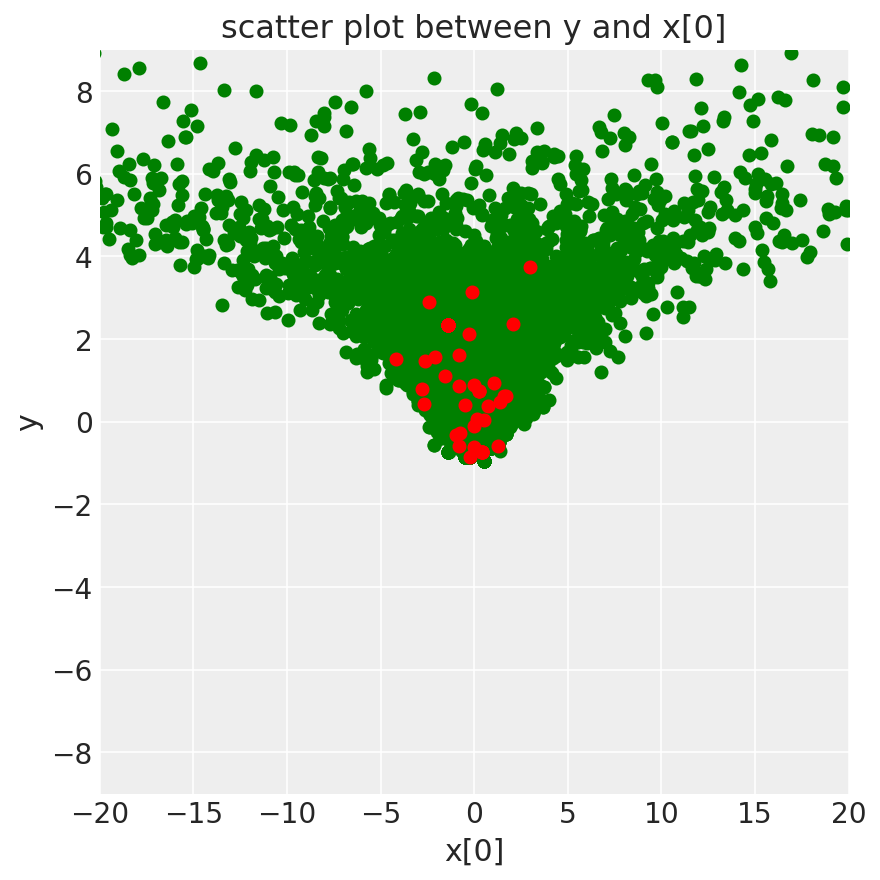

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[~ divergent], y[~ divergent], color='g')
plt.scatter(x0[divergent], y[divergent], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]');

* 上のプロットで分かるように、図の下の方の領域で全くサンプルが取られていない。

* $y$のヒストグラムを確認する。
 * yの周辺分布（下の式）は正規分布になるはずだが・・・
$$p(y) = \idotsint p(y, x_1, \ldots, x_9) dx_1 \cdots dx_9$$

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(*args, **kwargs)


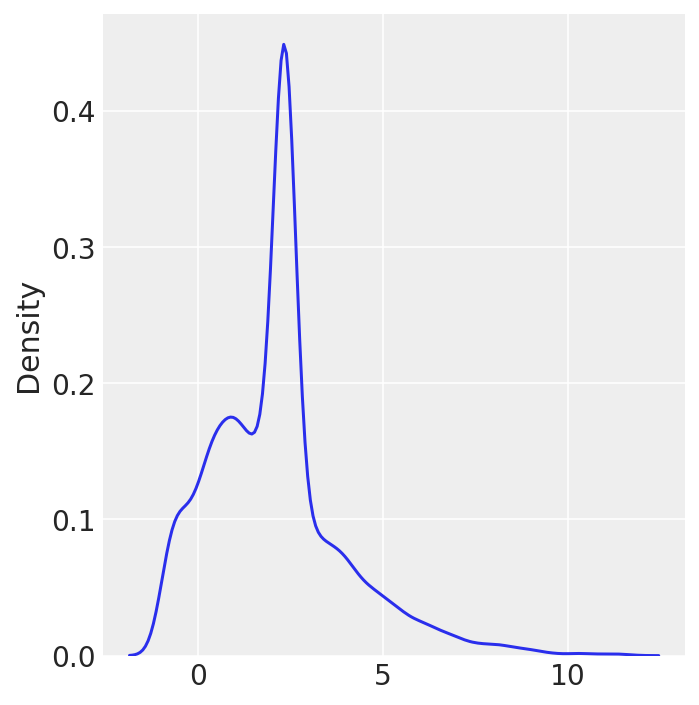

In [16]:
sns.displot(y, kind="kde");

### 5.2.2 実装方法 (2)
* これは、reparameterizationを使うことで改良された実装。
 * divergent transitionは起こらない。
 * $y$のサンプルのヒストグラムも正規分布の形を示す。

* 元のモデルは
$$\begin{align} 
y & \sim N(0, 3^2) \\
x_i & \sim N(0, e^y), \text{ $i=1,\ldots, 9$ }  
\end{align}$$


* $x_i$を$N(0, e^y)$からサンプリングする、という実装をやめて、代わりに
 * まず$x_\text{raw}$を$N(0,1)$からサンプリングし・・・
 * その$x_\text{raw}$を$x = e^{y/2} x_\text{raw}$という式で変換している。

In [17]:
with pm.Model() as model_revised:
  y = pm.Normal("y", mu=0, sd=3)
  x_raw = pm.Normal("x_raw", mu=0, sd=1, shape=9)
  x = pm.Deterministic("x", (y/2).exp() * x_raw)

In [18]:
with model_revised:
  trace_revised = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_raw, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


In [19]:
x0 = trace_revised['x'][:, 0]
y = trace_revised['y']
divergent = trace_revised['diverging']

In [20]:
divergent.sum()

0

Text(0.5, 1.0, 'scatter plot between y and x[0]')

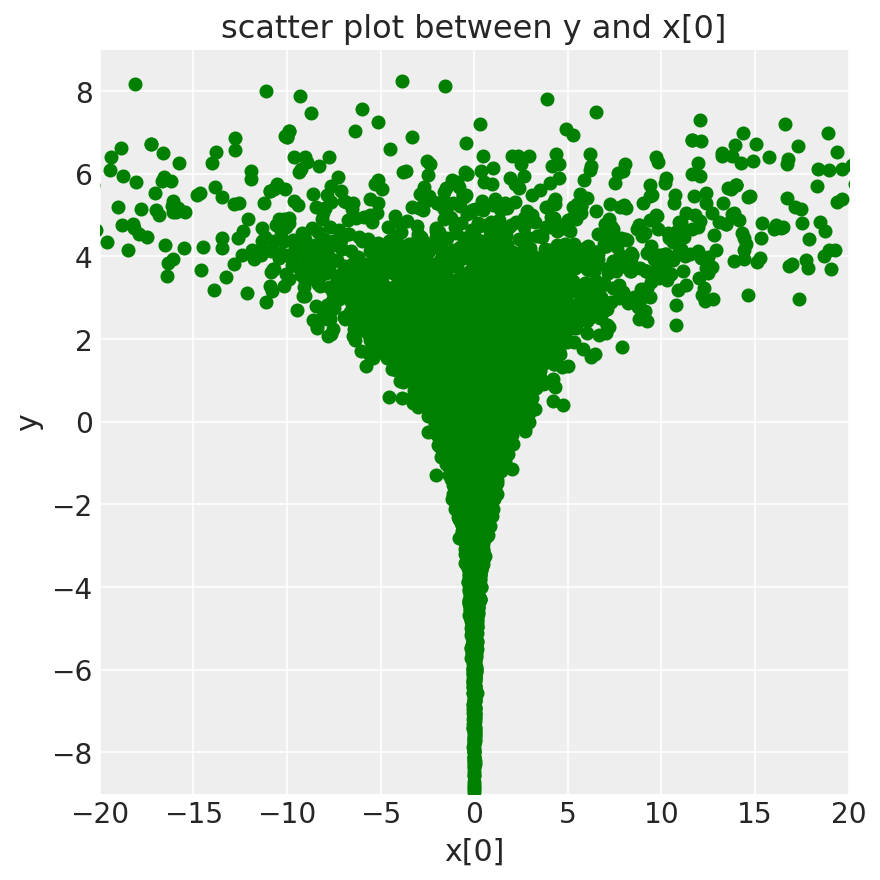

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[~ divergent], y[~ divergent], color='g')
plt.scatter(x0[divergent], y[divergent], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(*args, **kwargs)


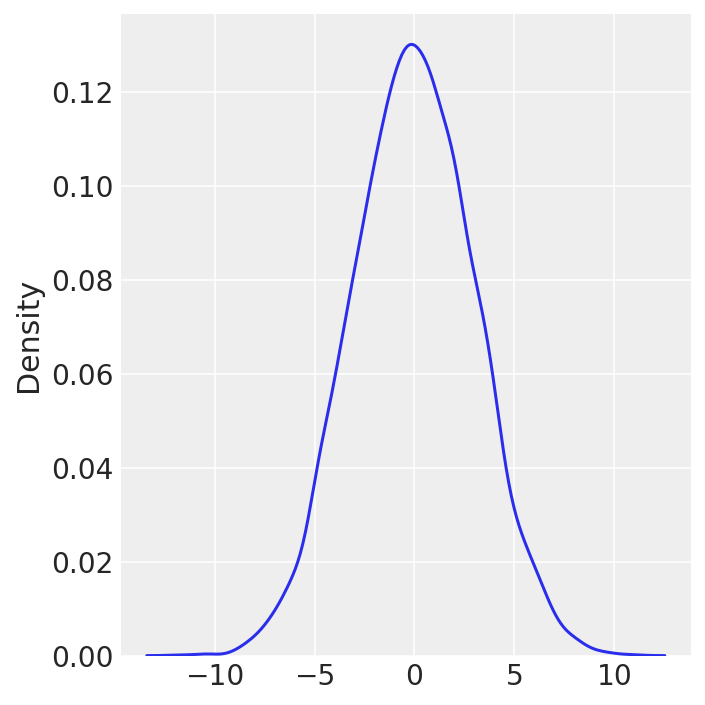

In [22]:
sns.displot(y, kind="kde")

## 5.3 The Eight Schools Model
* 下記Webページにある「A Centered Eight Schools Implementation」の実験を再現してみる。
 * https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html




> "Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore."



* arviz向けにコードを書き直した。

### 5.5.1 データセット
* `y`が観測データ
 * 各校で同じコーチングを実施し、その前後で学力テストの点数がどう変化したかを表す。
 * cf. https://tjo.hatenablog.com/entry/2020/03/23/231206
* `sigma`が既知のパラメータ

In [23]:
# Data of the Eight Schools Model
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12], dtype=float)
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18], dtype=float)
J = y.shape[0]

* このデータを以下のようにモデリングする。
$$\begin{align}
\mu & \sim N(0,5) \notag \\
\tau & \sim \text{Half-Cauchy}(5) \\
\theta_n & \sim N(\mu, \tau) \\
y_n & \sim N(\theta_n, \sigma_n^2)
\end{align}$$
 * $y_n$が上記コードの`y`に対応する。
 * $\sigma_n$が上記コードの`sigma`に対応する。

* Half-cauchy分布については下記ページを参照
 * https://distribution-explorer.github.io/continuous/halfcauchy.html
> "The Half-Cauchy distribution with 𝜇=0 is a useful prior for nonnegative parameters that may be very large, as allowed by the very heavy tails of the Half-Cauchy distribution."

### 5.5.2 実装方法(1)
* これは良くない実装方法。
 * 後でreparameterizationを使って改良する。

In [24]:
with pm.Model() as Centered_eight:
  mu = pm.Normal('mu', mu=0, sd=5)
  tau = pm.HalfCauchy('tau', beta=5)
  theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

* `return_inferencedata=True`としてarviz向けのサンプリング結果データを得る。　

In [25]:
with Centered_eight:
  trace = pm.sample(2000, cores=4, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6715532133279446, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6048750546796846, but should be close to 0.8. Try to increase the number of tuning steps.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6692396693610554, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampl

In [26]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.614,3.458,-1.546,10.691,0.369,0.349,95.0,1766.0,1.04
theta[0],6.446,5.571,-3.502,17.088,0.207,0.146,475.0,2518.0,1.02
theta[1],5.111,4.826,-3.881,14.014,0.316,0.224,214.0,3241.0,1.02
theta[2],4.070,5.538,-6.959,13.735,0.356,0.252,183.0,2581.0,1.02
theta[3],5.085,4.896,-4.079,14.007,0.299,0.211,229.0,2896.0,1.02
theta[4],3.849,4.876,-5.607,12.040,0.421,0.323,123.0,2340.0,1.03
theta[5],4.234,4.913,-4.618,13.629,0.362,0.277,181.0,2609.0,1.02
theta[6],6.580,5.095,-2.557,16.438,0.220,0.156,407.0,3032.0,1.01
theta[7],4.899,5.496,-6.172,14.211,0.256,0.181,315.0,2840.0,1.02
tau,3.814,3.087,0.485,9.406,0.224,0.158,58.0,18.0,1.07


* `r_hat`が1.0から離れているものもある。
* `tau`に問題がありそう。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.


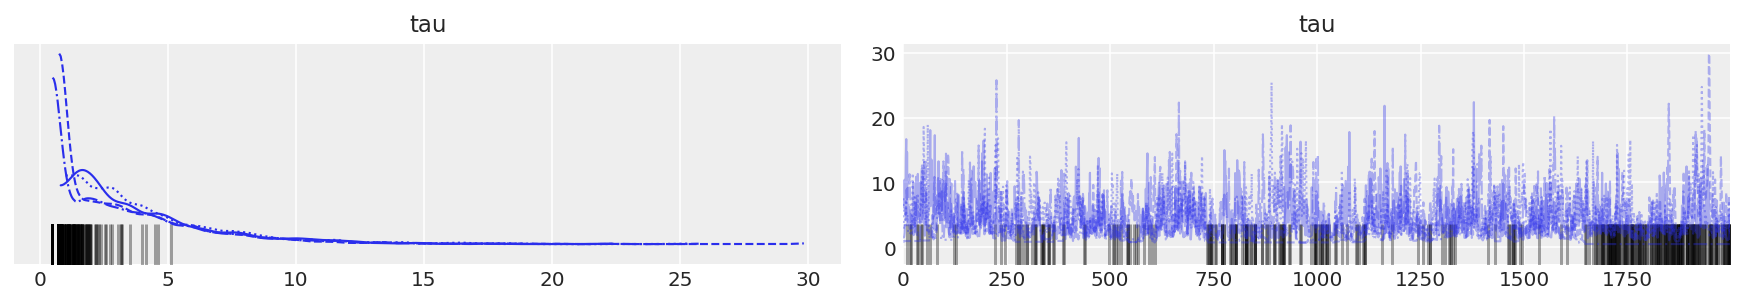

In [27]:
pm.traceplot(trace, var_names=['tau']);

* このデータについては$\tau$の"真の値"が分かっているらしい。
 * "真の値"の詳細は https://discourse.pymc.io/t/how-is-the-true-value-of-tau-in-the-eight-schools-model-known/1932
* logスケールでプロットして、真の値からのズレを見てみる。
 * $\log \tau$の真の値は0.7657852らしいです。

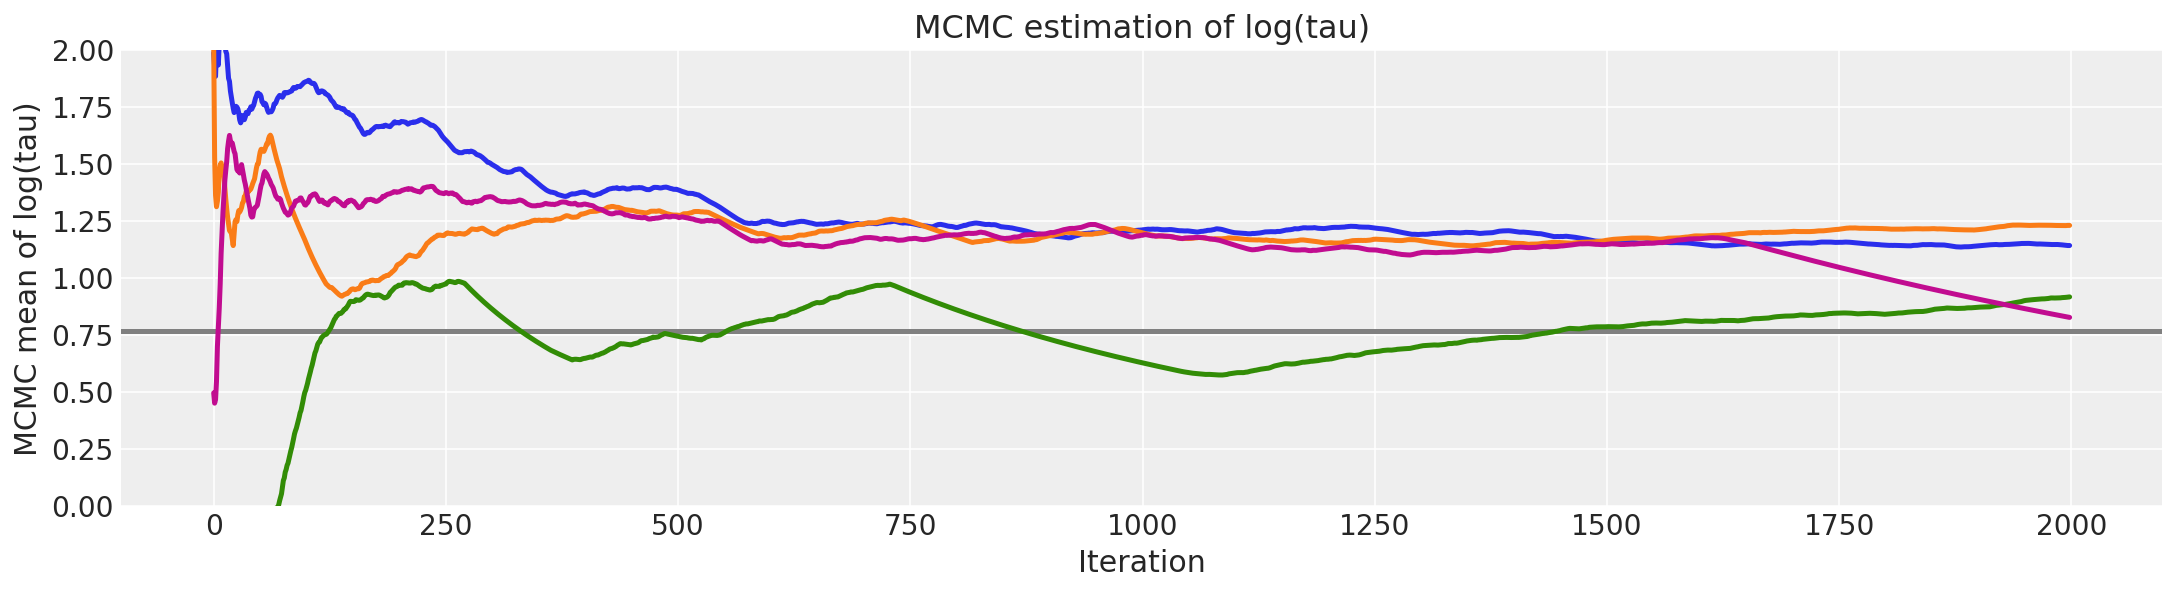

In [28]:
logtau = np.log(trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');

In [29]:
trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 2000)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables: (12/13)
    n_steps             (chain, draw) float64 15.0 15.0 31.0 ... 1.0 2.0 2.0
    diverging           (chain, draw) bool False False False ... True True True
    step_size_bar       (chain, draw) float64 0.3001 0.3001 ... 0.2213 0.2213
    step_size           (chain, draw) float64 0.2681 0.2681 ... 0.4188 0.4188
    energy              (chain, draw) float64 60.97 65.41 67.0 ... 43.24 43.38
    process_time_diff   (chain, draw) float64 0.003697 0.004062 ... 0.0006379
    ...                  ...
    acceptance_rate     (chain, draw) float64 0.9858 0.9792 ... 5.651e-123
    perf_counter_start  (chain, draw) float64 242.6 242.6 242.6 ... 258.4 258.4
    lp                  (chain, draw) float64 -59.58 -60.79 ... -41.07 -41.07
    tree_depth          (chain, draw) int64 4 4 5 5 4 4 4 4 ... 1 3 2 2 1 1 2 2
    energy_error        (chain, draw) float64 0.03561 -0.02173 ... 0.0 0.0
    max_energy_error    (chain, draw) float64 1.114 0.154 ... 1.024e+03
Attributes:
    created_at:                 2022-03-07T04:27:22.036781
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              23.856504440307617
    tuning_steps:               1000

In [30]:
trace.sample_stats.diverging

<xarray.DataArray 'diverging' (chain: 4, draw: 2000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [31]:
chain_id = 0
divergent = trace.sample_stats.diverging.data[chain_id]

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

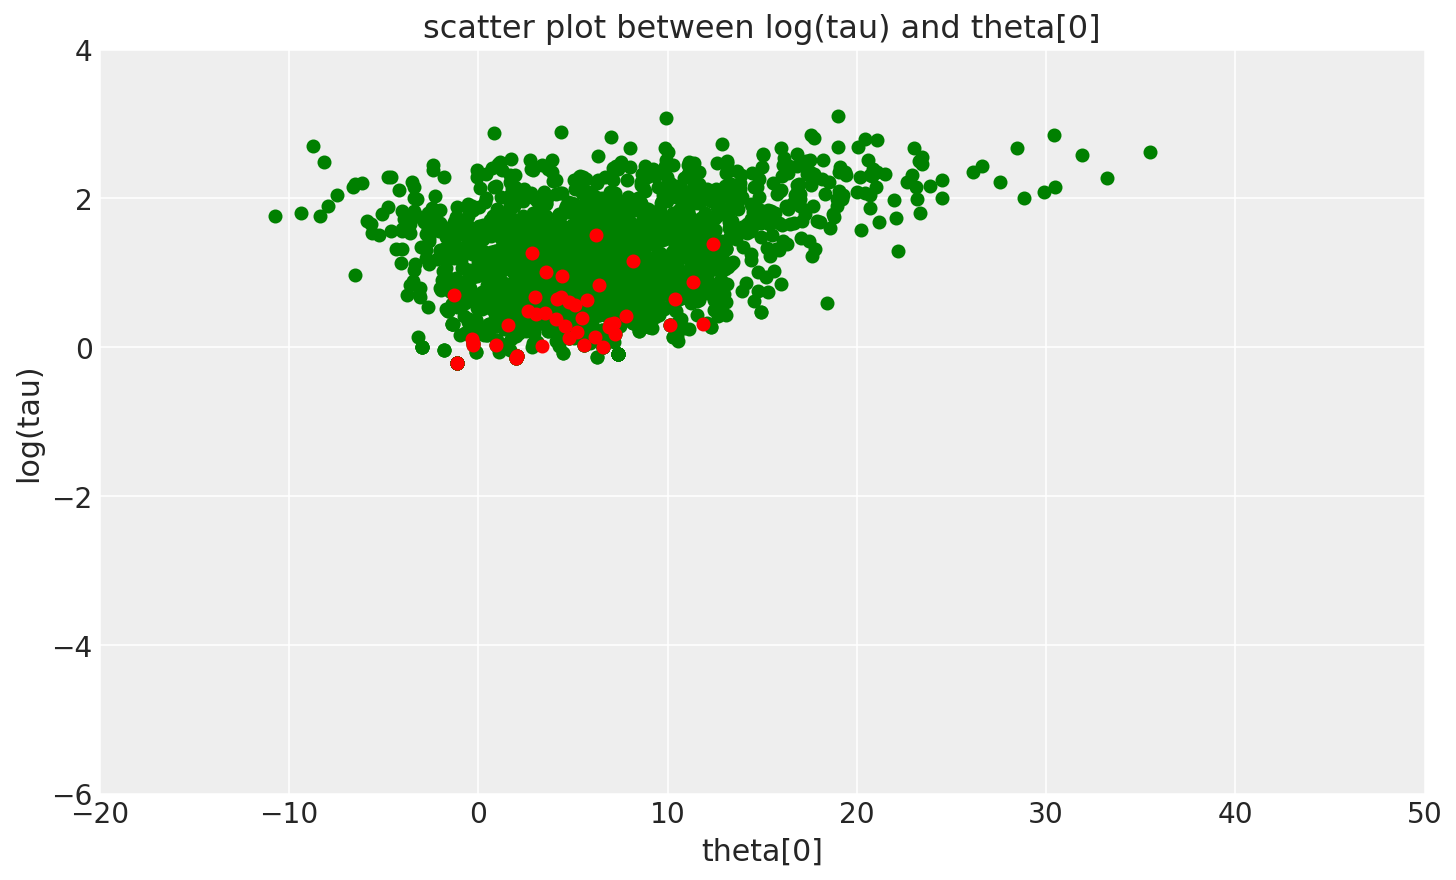

In [32]:
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

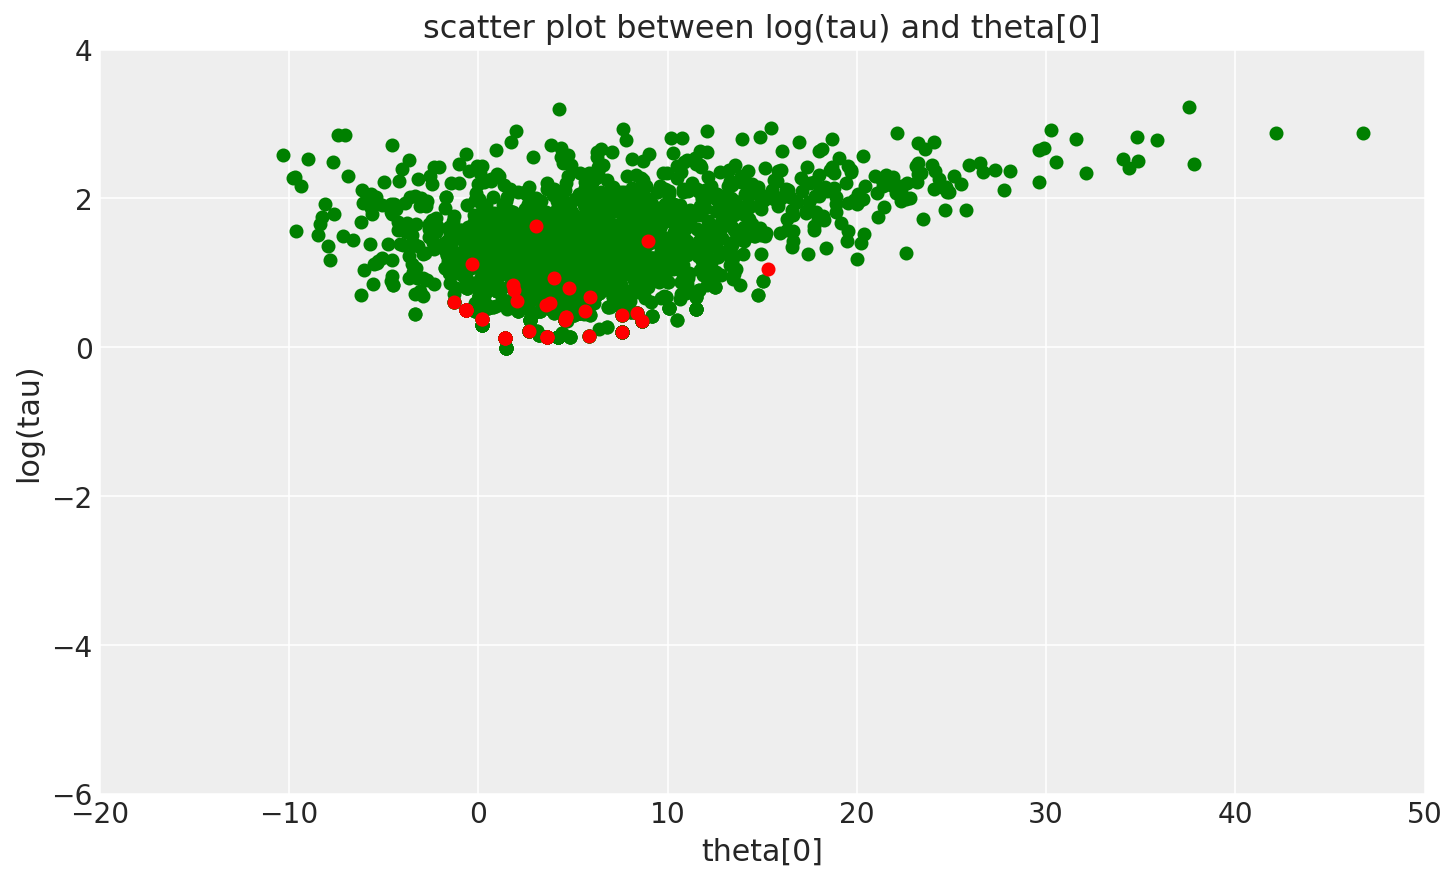

In [33]:
chain_id = 1
divergent = trace.sample_stats.diverging.data[chain_id]
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

### 5.5.3 実装方法(2)
* reparameterizationを使う。

* $\theta_i$を$N(\mu, \tau)$からサンプリングする、という実装をやめて、代わりに
 * まず$\tilde{\theta}_i$を$N(0,1)$からサンプリングし・・・
 * その$\tilde{\theta}_i$を$\theta_i = \mu + \tau \tilde{\theta}_i$という式で変換している。

In [34]:
with pm.Model() as NonCentered_eight:
  mu = pm.Normal('mu', mu=0, sd=5)
  tau = pm.HalfCauchy('tau', beta=5)
  theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
  theta = pm.Deterministic('theta', mu + tau * theta_tilde) # ここでreparameterizationを使用
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [35]:
with NonCentered_eight:
  trace = pm.sample(2000, cores=4, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [36]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.400,3.333,-2.032,10.468,0.042,0.031,6317.0,4290.0,1.0
theta_t[0],0.313,0.984,-1.487,2.173,0.011,0.011,7792.0,5166.0,1.0
theta_t[1],0.084,0.942,-1.671,1.874,0.010,0.011,8553.0,5254.0,1.0
theta_t[2],-0.099,0.976,-1.945,1.755,0.011,0.012,7847.0,4898.0,1.0
theta_t[3],0.086,0.934,-1.607,1.906,0.010,0.011,8265.0,4960.0,1.0
theta_t[4],-0.174,0.920,-1.882,1.549,0.011,0.011,7477.0,4929.0,1.0
theta_t[5],-0.068,0.931,-1.864,1.684,0.011,0.011,6734.0,5004.0,1.0
theta_t[6],0.355,0.976,-1.503,2.166,0.011,0.012,7649.0,4791.0,1.0
theta_t[7],0.095,0.986,-1.769,1.884,0.012,0.012,7074.0,4614.0,1.0
tau,3.686,3.264,0.001,9.398,0.058,0.045,3107.0,2914.0,1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcabe3db6d0>,
      dtype=object)

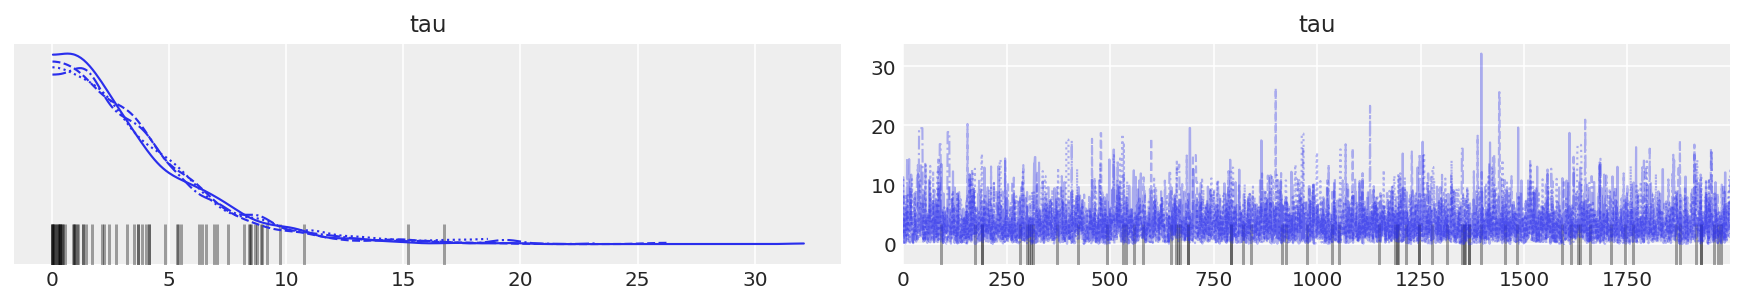

In [37]:
pm.traceplot(trace, var_names=['tau'])

Text(0.5, 1.0, 'MCMC estimation of log(tau)')

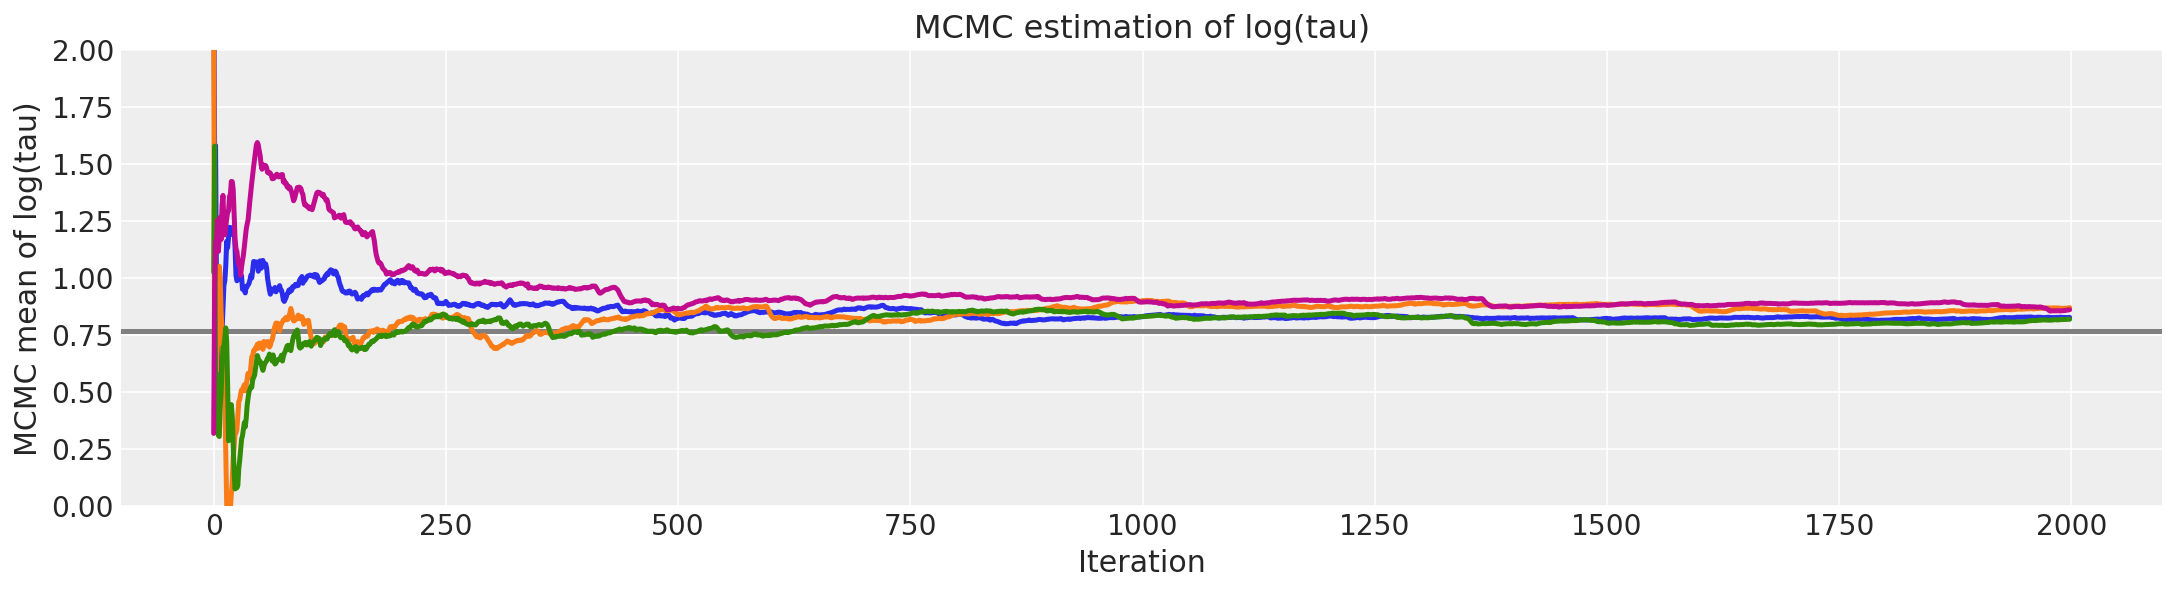

In [38]:
logtau = np.log(trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

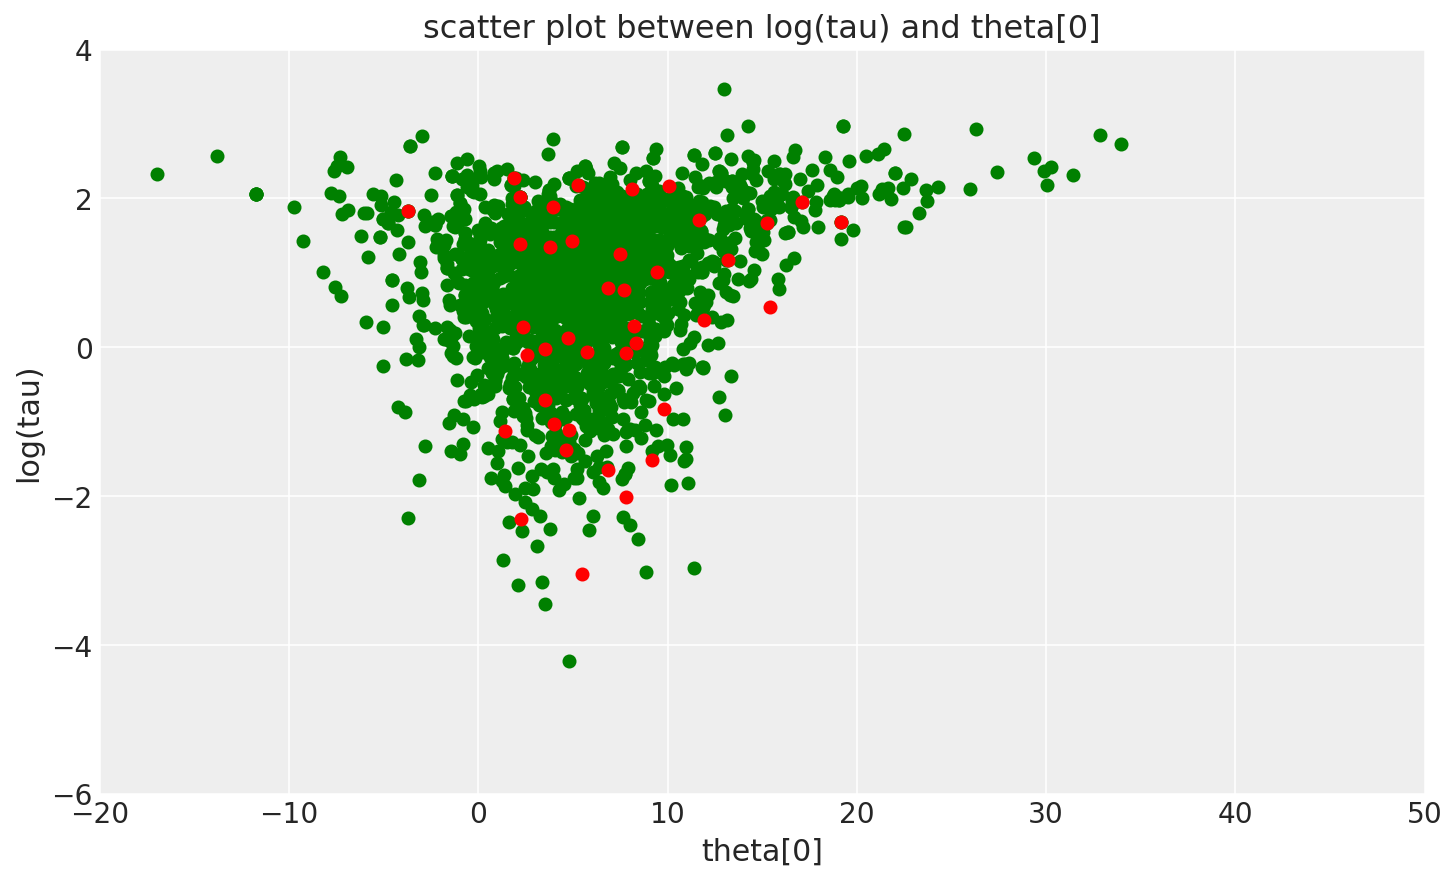

In [39]:
chain_id = 0
divergent = trace.sample_stats.diverging.data[chain_id]
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

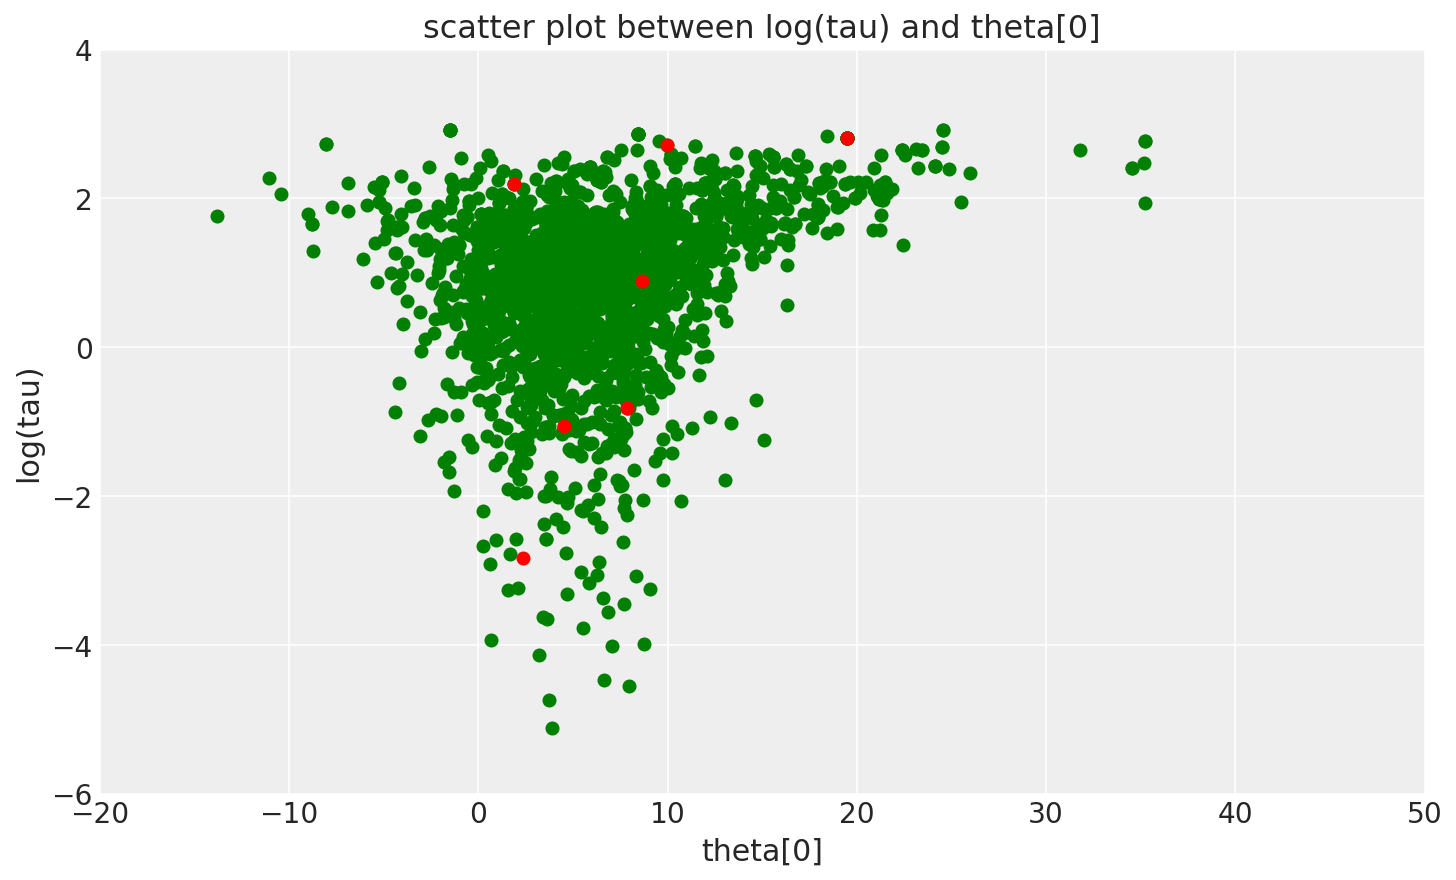

In [40]:
chain_id = 1
divergent = trace.sample_stats.diverging.data[chain_id]
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

### 5.5.4 採択率(acceptance rate)を調整する

> "target_accept : float in [0, 1]. The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors." (https://docs.pymc.io/api/inference.html ) 


In [41]:
with NonCentered_eight:
  step = pm.NUTS(target_accept=.90)
  trace = pm.sample(2000, step=step, cores=4, random_seed=SEED, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [42]:
with NonCentered_eight:
  step = pm.NUTS(target_accept=.95)
  trace = pm.sample(2000, step=step, cores=4, random_seed=SEED, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


Text(0.5, 1.0, 'MCMC estimation of log(tau)')

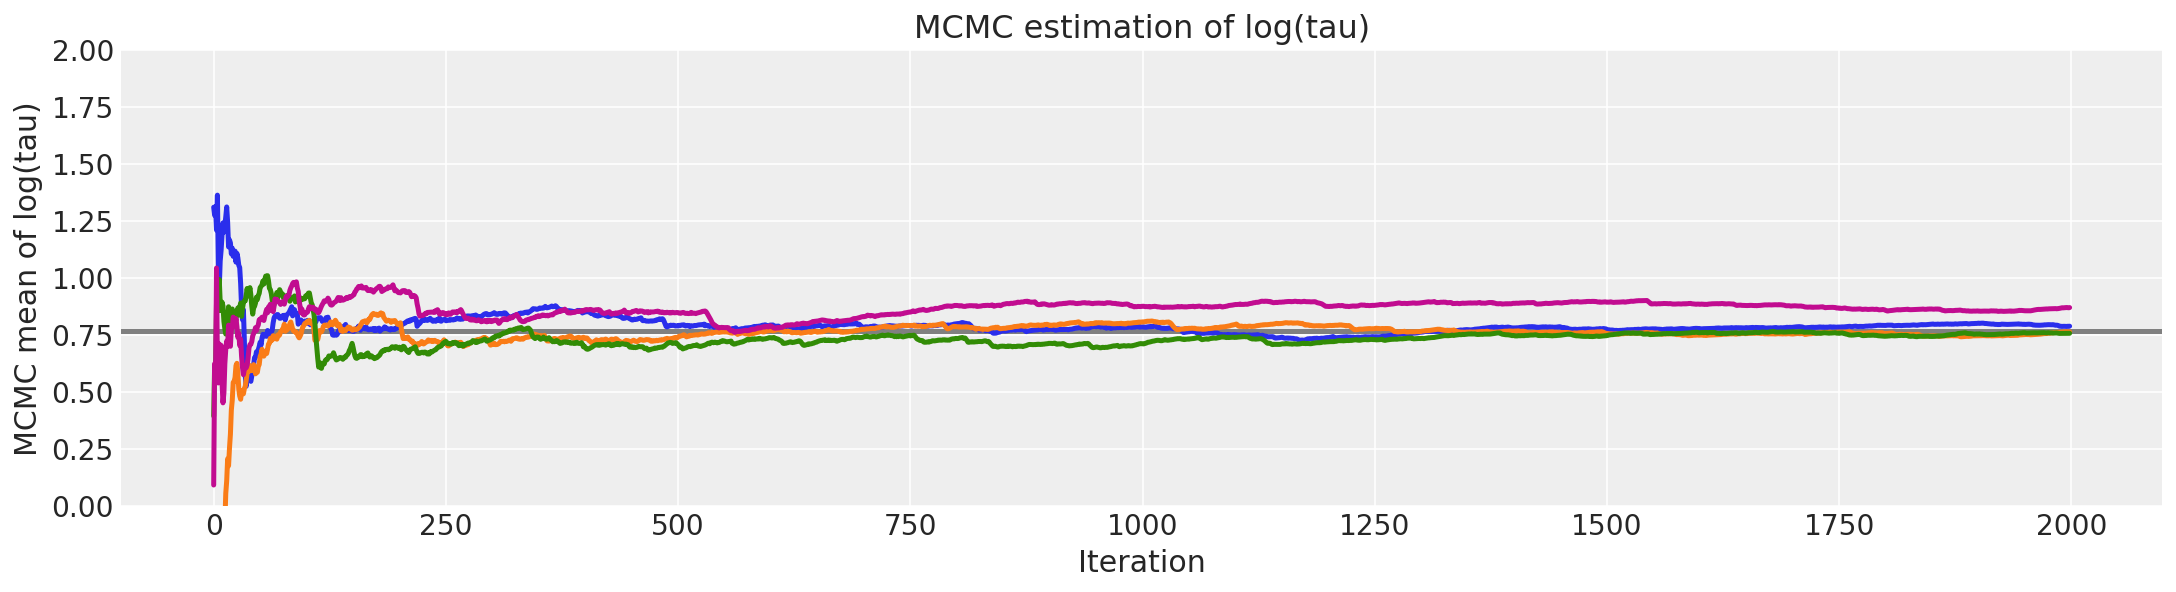

In [43]:
logtau = np.log(trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')